In [14]:
import torch
import random
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import argparse,os,time
import os
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import librosa
import librosa.display
import torchaudio
import torchaudio.transforms as AT

In [15]:
num_gpus=4

In [16]:
y_data = pd.read_csv('train_answer.csv', index_col=0)
y_data = y_data.values

In [17]:
def data_loader(files):
    out = []
    for file in tqdm(files):
        fs, data = wavfile.read(file)
        out.append(data)    
    out = np.array(out,dtype=np.float32)
    return out

In [18]:
x_data = sorted(glob('./train/*.wav'))
x_data=data_loader(x_data)

100%|██████████| 100000/100000 [00:03<00:00, 31724.57it/s]


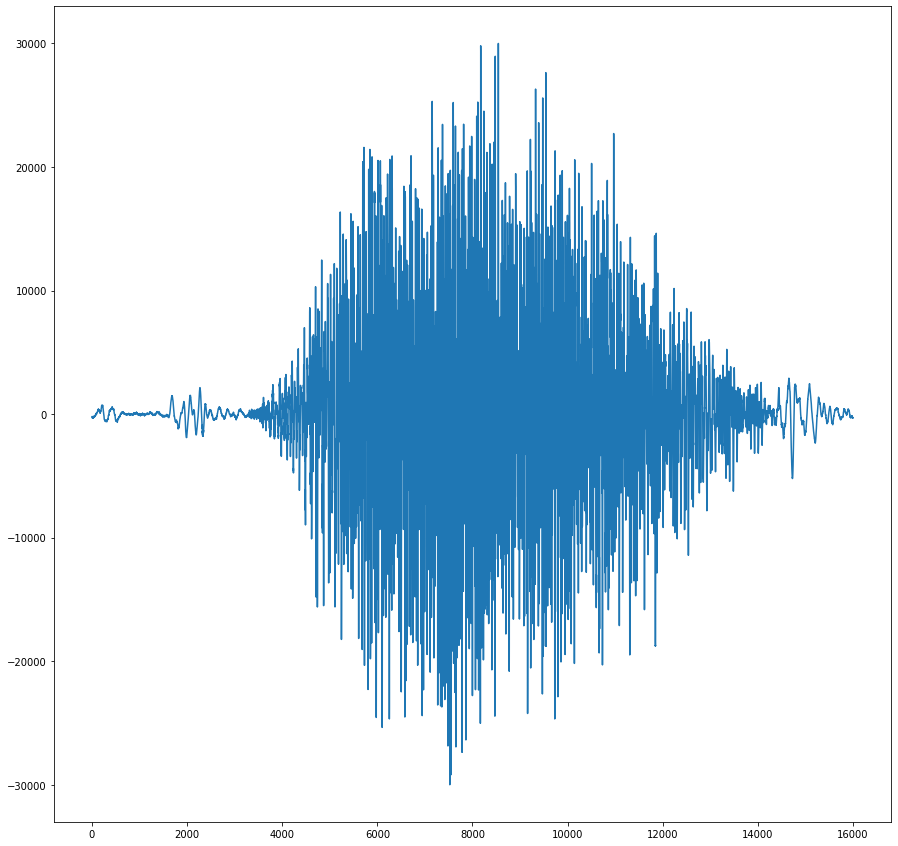

In [19]:
plt.figure(figsize=(15,15))
plt.plot(x_data[1])

In [20]:
x_data.shape

(100000, 16000)

In [21]:
y_data.shape

(100000, 30)

In [8]:
mel_spectrogram = nn.Sequential(
    AT.MelSpectrogram(sample_rate=16000, 
                      n_fft=512, 
                      win_length=400,
                      hop_length=160,
                      n_mels=80),
    AT.AmplitudeToDB()
)

In [9]:
mel0 = mel_spectrogram(torch.tensor(x_data[0])).view(1,1,80,101)
mel1 = mel_spectrogram(torch.tensor(x_data[1])).view(1,1,80,101)
mel=torch.cat((mel0,mel1),0)
for i in range(2,100000):
    if i%1000==0:
        print(i)
    mel_temp=mel_spectrogram(torch.tensor(x_data[i])).view(1,1,80,101)
    mel=torch.cat((mel,mel_temp),0)
print(mel.shape)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
torch.Size([100000, 1, 80, 101])


In [10]:
class CustomDataset(Dataset):
    def __init__(self,x_dat,y_dat):
        x = x_dat
        y = y_dat
        self.len = x.shape[0]
        y=y.astype('float32')
        x=x.astype('float32')
        self.x_data = torch.tensor(x)
        self.y_data = torch.tensor(y)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [20]:
train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(mel.numpy(),y_data, 
                                                                        test_size=0.2)

In [21]:
batch_size=256
train_dataset = CustomDataset(train_data_x,train_data_y)
train_loader = DataLoader(dataset=train_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)
test_dataset = CustomDataset(test_data_x,test_data_y)
test_loader = DataLoader(dataset=test_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)


In [22]:
class VRModel(torch.nn.Module):
    def __init__(self):
        super(VRModel, self).__init__()
        self.layer_1 = nn.Conv2d(1,8,(4,5),2)
        self.act_1 = nn.ReLU()
        
        self.layer_2 = nn.Conv2d(8,16,(4,5),2)
        self.act_2 = nn.ReLU()
        
        self.layer_3 = nn.Conv2d(16,32,(4,5))
        self.act_3 = nn.ReLU()
        
        self.layer_4 = nn.Conv2d(32,64,(4,4))
        self.act_4 = nn.ReLU()
        
        self.layer_5 = nn.Conv2d(64,64,(3,4),(2,3))
        self.act_5 = nn.ReLU()

        
        self.fc_layer_1 = nn.Linear(25*64,256)
        self.act_7 = nn.ReLU()
        
        self.bnm1=nn.BatchNorm1d(256)
        
        self.fc_layer_2 = nn.Linear(256,256)
        self.act_8 = nn.ReLU()
        
        self.bnm2=nn.BatchNorm1d(256)
        
        self.fc_layer_3 = nn.Linear(256,256)
        self.act_9 = nn.ReLU()
        
        self.bnm3=nn.BatchNorm1d(256)
        
        self.fc_layer_4 = nn.Linear(256,30)
        
        self.act_10=torch.nn.Softmax(dim=1)
        
        

    def forward(self, x):
        x = x.view(batch_size//num_gpus,1,80,101)
        out = self.layer_1(x)
        out = self.act_1(out)
        for module in list(self.modules())[2:-11]:
            out = module(out)
        out = out.view(batch_size//num_gpus,-1)
        for module in list(self.modules())[-11:]:
            out = module(out)
        return out

In [23]:
model=nn.DataParallel(VRModel())
if torch.cuda.is_available():
    model.cuda()
criterion=nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(model.parameters())

In [25]:
trn_loss_list = []
val_loss_list = []
total_epoch=100
for epoch in range(total_epoch):
    trn_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs=inputs.cuda()
            labels=labels.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        output= model(inputs)
        # calculate loss
        loss=criterion(output.log(), labels)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del output
    with torch.no_grad():
        val_loss = 0.0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            if torch.cuda.is_available():
                val_x = val_x.cuda()
                val_label =val_label.cuda()
            val_output = model(val_x)
            v_loss = criterion(val_output.log(), val_label)
            val_loss += v_loss
    del val_output
    del v_loss
            
    trn_loss_list.append(trn_loss/len(train_loader))
    val_loss_list.append(val_loss/len(test_loader))
    now = time.localtime()
    print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))

    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} \n".format(
                epoch+1, total_epoch, trn_loss / len(train_loader), val_loss / len(test_loader)
            ))   

2020/09/05 19:18:38
epoch: 1/100 | trn loss: 1.4157 | val loss: 1.3552 

2020/09/05 19:19:30
epoch: 2/100 | trn loss: 1.2856 | val loss: 1.2758 

2020/09/05 19:20:21
epoch: 3/100 | trn loss: 1.2016 | val loss: 1.2174 

2020/09/05 19:21:14
epoch: 4/100 | trn loss: 1.1411 | val loss: 1.1879 

2020/09/05 19:22:07
epoch: 5/100 | trn loss: 1.0911 | val loss: 1.1640 

2020/09/05 19:23:00
epoch: 6/100 | trn loss: 1.0523 | val loss: 1.1530 

2020/09/05 19:23:53
epoch: 7/100 | trn loss: 1.0179 | val loss: 1.1449 

2020/09/05 19:24:46
epoch: 8/100 | trn loss: 0.9881 | val loss: 1.1334 

2020/09/05 19:25:39
epoch: 9/100 | trn loss: 0.9595 | val loss: 1.1290 

2020/09/05 19:26:34
epoch: 10/100 | trn loss: 0.9348 | val loss: 1.1454 

2020/09/05 19:27:27
epoch: 11/100 | trn loss: 0.9123 | val loss: 1.1309 

2020/09/05 19:28:21
epoch: 12/100 | trn loss: 0.8898 | val loss: 1.1337 

2020/09/05 19:29:15
epoch: 13/100 | trn loss: 0.8696 | val loss: 1.1399 

2020/09/05 19:30:11
epoch: 14/100 | trn loss: 0

In [26]:
torch.save(model, "model_fin")
print("model saved complete")

model saved complete
